## Importing Libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import ParameterSampler

## Data Loading

In [3]:
movies_path = 'https://raw.githubusercontent.com/Bansal0527/Movie-Recomendation-System/master/Dataset/movies.csv'
ratings_path = 'https://raw.githubusercontent.com/Bansal0527/Movie-Recomendation-System/master/Dataset/ratings.csv'

## Data Pre Processing

In [4]:
movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Filter recommendations using movieId, retrieve titles from dataset. Ignore genres in this filtering approach. This simplifies and streamlines the recommendation process.

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Use userId to uniquely identify users, movieId to retrieve movie titles from the dataset. Ratings provided by users to predict top 10 similar movies, facilitating personalized recommendations based on user preferences.

We'll rearrange the data to make it easier to understand. Each column will represent a unique user, and each row will represent a unique movie.

In [7]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


From, this table we can interpret that the user1 only gave ratings for movie number 1 and 3 and did not rate movie number 2. Similarly user 5 did not rate movie 1 but rated 2, 3 , 4, 5.

# Removing Noise from Data

Looking at the above table... It contains a lot of NULL values, so we will substitute these NULL values with 0.

In [8]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


# Finding the parameters for optimal sparsity

In [12]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

In [13]:
param_space = {
    'min_user_votes': range(10, 101),
    'min_movie_votes': range(30, 101)
}
n_iter = 100
best_score = float('inf')
best_params = None
param_sampler = ParameterSampler(param_space, n_iter=n_iter, random_state=42)
for params in param_sampler:
  filtered_ratings = ratings.copy()
  user_counts = filtered_ratings['userId'].value_counts()
  movie_counts = filtered_ratings['movieId'].value_counts()
  filtered_ratings = filtered_ratings[filtered_ratings['userId'].isin(user_counts[user_counts >= params['min_user_votes']].index)]
  filtered_ratings = filtered_ratings[filtered_ratings['movieId'].isin(movie_counts[movie_counts >= params['min_movie_votes']].index)]
  sparsity = 1 - len(filtered_ratings) / (len(ratings) * len(movies))
  if sparsity < best_score:
    best_score = sparsity
    best_params = params

print("Best parameters:", best_params)
print("Best sparsity score:", best_score)

Best parameters: {'min_user_votes': 15, 'min_movie_votes': 31}
Best sparsity score: 0.9999416111038673


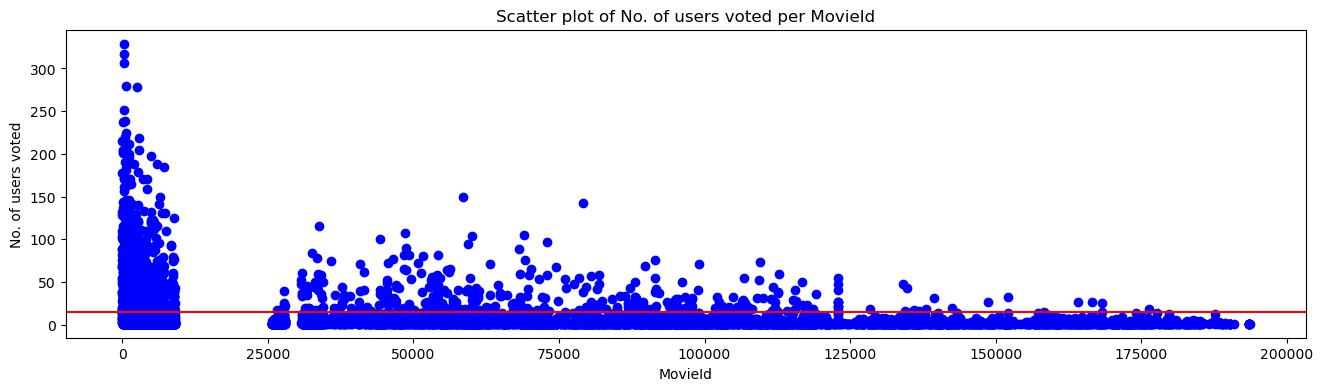

In [15]:
f, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.scatter(no_user_voted.index, no_user_voted, color='blue')
plt.axhline(y=best_params['min_user_votes'], color='r')  # Plotting the best min_user_votes
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.title('Scatter plot of No. of users voted per MovieId')
plt.show()

In [16]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 15].index, :]

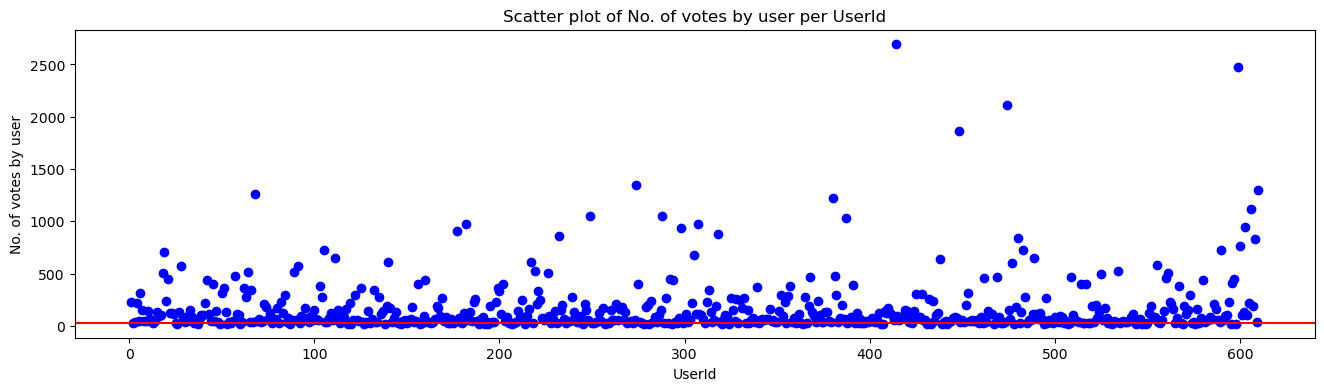

In [17]:
# Plot scatter plot of No. of votes by user per UserId
f, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.scatter(no_movies_voted.index, no_movies_voted, color='blue')
plt.axhline(y=best_params['min_movie_votes'], color='r') 
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.title('Scatter plot of No. of votes by user per UserId')
plt.show()

In [18]:
final_dataset = final_dataset.loc[:, no_movies_voted[no_movies_voted > 31].index]
final_dataset

userId,1,3,4,5,6,7,8,9,10,11,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
164179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
166528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


# Finding whether a movie is present or not

Retrieve the movie ID corresponding to a given movie name from a DataFrame. Requires the movie name as a string and a DataFrame containing movie data with a 'movieId' column. Returns the movie ID as an integer if found; otherwise, returns None if the movie name is not present in the DataFrame.

In [19]:
def get_movie_id(movie_name, movies_df):
  # Check if the movie name exists in the DataFrame
  movie = movies_df[movies_df['title'].str.contains(movie_name, case=False)]

  if not movie.empty:
    return movie.iloc[0]['movieId']
  else:
    return None

movie_name = 'Memento'
movie_id = get_movie_id(movie_name, movies)
print(f"The movie ID for '{movie_name}' is: {movie_id}")

The movie ID for 'Memento' is: 4226


# Calculating the Similarity matrix

Compute cosine similarity matrix for a dataset using pandas DataFrame input. Each row represents an item, columns denote features. Output is a numpy array containing cosine similarity values between all pairs of items in the dataset.

In [20]:
# Calculate cosine similarity matrix
def cosine_similarity_matrix(data):
  data_normalized = data.div(np.sqrt(np.square(data).sum(axis=1)), axis=0)
  similarity_matrix = data_normalized.dot(data_normalized.T)
  return similarity_matrix.values

cosine_sim = cosine_similarity_matrix(final_dataset)
cosine_sim

array([[1.        , 0.42783111, 0.29719794, ..., 0.1823281 , 0.1730078 ,
        0.15747847],
       [0.42783111, 1.        , 0.29364301, ..., 0.236048  , 0.28372346,
        0.22120298],
       [0.29719794, 0.29364301, 1.        , ..., 0.0592274 , 0.06237276,
        0.08759053],
       ...,
       [0.1823281 , 0.236048  , 0.0592274 , ..., 1.        , 0.66625324,
        0.49332989],
       [0.1730078 , 0.28372346, 0.06237276, ..., 0.66625324, 1.        ,
        0.50584467],
       [0.15747847, 0.22120298, 0.08759053, ..., 0.49332989, 0.50584467,
        1.        ]])

# Implementing KNN

In [21]:
def find_k_nearest_neighbors(movie_idx, k=20):
  distances = cosine_sim[movie_idx]
  nearest_neighbors = np.argsort(distances)[-(k+1):]
  nearest_distances = distances[nearest_neighbors]
  return nearest_neighbors, nearest_distances

# Movie Recommendation

In [24]:
def get_movie_recommendation(movie_name, k=10):
  movie_name = movie_name.lower()
  movie = movies[movies['title'].str.lower().str.contains(movie_name, case=False)]
  if not movie.empty:
    movie_id = movie.iloc[0]['movieId']
    movie_idx = final_dataset.index.get_loc(movie_id)
    if movie_idx is not None:
      nearest_neighbors, nearest_distances = find_k_nearest_neighbors(movie_idx, k)
      recommend_frame = []
      for neighbor, distance in zip(nearest_neighbors, nearest_distances):
        movie_id = final_dataset.index[neighbor]
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        movie_genre = movies[movies['movieId'] == movie_id]['genres'].values[0]
        recommend_frame.append({'Title': movie_title, 'Genre': movie_genre, 'Distance': distance})
      df = pd.DataFrame(recommend_frame)
      return df
    else:
      return "No movies found. Please check your input."

input_movie = "Memento"
get_movie_recommendation(input_movie)

,Title,Genre,Distance
0,Big Hero 6 (2014),Action|Animation|Comedy,0.613192
1,Edge of Tomorrow (2014),Action|Sci-Fi|IMAX,0.617604
2,Captain America: The First Avenger (2011),Action|Adventure|Sci-Fi|Thriller|War,0.622002
3,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi,0.622008
4,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX,0.640426
5,Ant-Man (2015),Action|Adventure|Sci-Fi,0.647721
6,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,0.648466
7,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX,0.650769
8,X-Men: Days of Future Past (2014),Action|Adventure|Sci-Fi,0.651446
9,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,0.735036
